# DAA Experiment Harness (Template)
**Tujuan**: kerangka eksperimen untuk membandingkan *Algoritma Depth First Search* vs *Algoritma Breadth First Search* pada instance unik per kelompok.
1. Isi `DFS` dan `BFS`.
2. Sesuaikan `generate_instances` atau loader data.
3. Atur `Ns`, `repeats`, `seed`.


## **Pembuatan Graph**

### Import Library (Keseluruhan)

In [298]:
import os, time, random, statistics
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
import ipywidgets as widgets
from IPython.display import display, clear_output
import json
import gc

gc.disable
# Buat folder data jika belum ada
os.makedirs("data", exist_ok=True)

### Generate Instances

In [299]:
def generate_bem_graph(n_total, seed):
    random.seed(seed)
    n_a = int(n_total * 0.4)
    n_b = int(n_total * 0.35)
    n_c = n_total - n_a - n_b
    G_A = nx.barabasi_albert_graph(n=n_a, m=10, seed=seed)
    G_B = nx.barabasi_albert_graph(n=n_b, m=10, seed=seed+1)
    G_C = nx.barabasi_albert_graph(n=n_c, m=10, seed=seed+2)
    G_total = nx.disjoint_union_all([G_A, G_B, G_C])
    G_total.add_edge(0, n_a)             
    G_total.add_edge(n_a, n_a + n_b)
    G_total.add_edge(0, n_a + n_b)     
    node_data = {}
    nama = []
    file = open("data/nama.csv","a+")
    file.seek(0)
    for i in file.readlines() :
        nama.append(i)
    file.close()
    nnama = len(nama) - 1
    for node_id in G_total.nodes():
        if node_id < n_a:
            divisi = "Divisi Acara"
            jabatan = "Ketua Divisi" if node_id == 0 else "Staff"
        elif node_id < (n_a + n_b):
            divisi = "Divisi Humas"
            jabatan = "Ketua Divisi" if node_id == n_a else "Staff"
        else:
            divisi = "Divisi Logistik"
            jabatan = "Ketua Divisi" if node_id == (n_a + n_b) else "Staff"
        nama1 = nama.pop(random.randint(0,nnama)).strip()
        nnama -= 1
        node_data[node_id] = {
            "nama": nama1,
            "divisi": divisi,
            "jabatan": jabatan,
            "ipk": round(random.uniform(2.5, 4.0), 2)
        }
    adj_list = nx.to_dict_of_lists(G_total)
    file = open(f"data/Biodata N{n_total} seed({seed}).csv","w")
    file.write("id;nama;divisi;jabatan;ipk\n")
    for i in range(n_total) :
        file.write(f"{i};{node_data[i]['nama']};{node_data[i]['divisi']};{node_data[i]['jabatan']};{node_data[i]['ipk']}\n")
    
    return adj_list, node_data

## Implementasi Algoritma DFS (Depth First Search)

### DFS Searching

In [300]:
def dfs(adj_list,start,goal,hasil) :
    for i in adj_list[start] :
        if i not in hasil and i != start :
            hasil[i] = [start]
            if i == goal :
                return True
            if dfs(adj_list,i,goal,hasil) :
                return True
    return False

### DFS Transversal

O(n) = `1e + (n-1) + 1`

Theta = `e + (n-1) + 1` 

In [301]:
def dfs_trans(adj_list,start,hasil,sepuh) :
    for i in adj_list[start] :                  # e
        if i not in hasil and i != sepuh :      # 1
            hasil[i] = [start]                  # 1     t n-1
            dfs_trans(adj_list,i,hasil,sepuh)
    return hasil                                # 1

## Implementasi Algoritma BFS (Breadth First Search)

### BFS Searching

In [302]:
def bfs(adj_list,start,goal,hasil) :
    qiu = [start]
    while qiu :
        cabang = qiu.pop(0)
        for i in adj_list[cabang] :
            if i not in hasil :
                hasil[i] = [cabang]
                qiu.append(i)
            if i == goal :
                return True
    return False

### BFS Transversal

O(n) = `2 + n + 2(n-1) + e + 1`

Theta = `n + 2(n-1) + e + 3`

In [303]:
def bfs_trans(adj_list,start,hasil,useless) :
    hasil[start] = []                           # 1
    qiu = [start]                               # 1
    while qiu :                                 # n
        cabang = qiu.pop(0)                     # 1     t n
        for i in adj_list[cabang] :             # n_e   t e
            if i not in hasil :                 # 1
                hasil[i] = [cabang]             # 1     t n-1
                qiu.append(i)                   # 1     t n-1
    return hasil                                # 1

## Evaluator & Timing

In [304]:
# def evaluate_solution(sol):
#     # Untuk sorting: gap=0 jika terurut.
#     return 0.0 if isinstance(sol, list) and all(sol[i]<=sol[i+1] for i in range(len(sol)-1)) else 1.0

def run_once(algorithm, adj_list,start,hasil,sepuh):
    t0=time.perf_counter(); out=algorithm(adj_list,start,hasil,sepuh); dt=(time.perf_counter()-t0)*1000.0
    return dt, out

## Eksekusi Eksperimen

In [305]:
# Tak Boleh Diganti
Ns=[100,400,700,1000]
rows=[]
base_seed= 121437 
graph = {}
tree_dfs = {}
tree_bfs = {}

# Boleh Diganti
repeats=5    
start = 5
n_seed = 1
newrun = True

for n in Ns:
    for r in range(repeats):
        if newrun :
            if r < n_seed :
                adj_list, node_data = generate_bem_graph(n, base_seed + r)
                output_content = {
                    "project": "connected_components_social_graph",
                    "description": f"Graf BEM {n} nodes dengan Data Atribut",
                    "n_nodes": n,
                    "graph_adj": adj_list,
                    "node_data": node_data
                }       
        filename = f"data/social_graph_N{n} seed({base_seed + r%n_seed}).json"

        if newrun and r < n_seed :
            with open(filename, "w") as f:
                json.dump(output_content, f, indent=2)
            
        else :
            with open(filename, "r") as f:
                data = json.load(f)
            adj_list = {int(k): v for k, v in data["graph_adj"].items()}

        gc.collect
        dA, hasilA = run_once(dfs_trans, adj_list,start,{},start)
        gc.collect
        dB, hasilB = run_once(bfs_trans, adj_list,start,{},start)
        
        rows.append({'n':n,'repeat':r,'algo':'DFS','time_ms':dA})#,'gap':gA})
        rows.append({'n':n,'repeat':r,'algo':'BFS','time_ms':dB})#,'gap':gB})

        if r < n_seed :
            graph[f"Graph N{n} seed({base_seed + r})"] = adj_list
            tree_dfs[f"DFS N{n} seed({base_seed + r})"] = hasilA
            tree_bfs[f"BFS N{n} seed({base_seed + r})"] = hasilB

df=pd.DataFrame(rows)
display(df)

os.makedirs("results", exist_ok=True)
file = open("results/experiment_raw.csv","a+")
file.close()
df.to_csv('results/experiment_raw.csv', index=False)
summary=df.groupby(['algo','n']).agg(time_ms_mean=('time_ms','mean'),time_ms_median=('time_ms','median'), time_ms_sd=('time_ms','std')).reset_index() #, gap_mean=('gap','mean')).reset_index()
summary.to_csv('results/summary.csv', index=False)

display(summary)

,n,repeat,algo,time_ms
0,100,0,DFS,0.1628
1,100,0,BFS,0.1754
2,100,1,DFS,0.0804
3,100,1,BFS,0.0793
4,100,2,DFS,0.0790
5,100,2,BFS,0.0624
6,100,3,DFS,0.0685
7,100,3,BFS,0.0665
8,100,4,DFS,0.0694
9,100,4,BFS,0.0627


,algo,n,time_ms_mean,time_ms_median,time_ms_sd
0,BFS,100,0.08926,0.0665,0.048642
1,BFS,400,0.48132,0.4002,0.199765
2,BFS,700,0.76880,0.6915,0.152379
3,BFS,1000,1.16888,1.1628,0.186184
4,DFS,100,0.09202,0.0790,0.039935
5,DFS,400,0.56788,0.5308,0.080949
6,DFS,700,1.20606,1.1773,0.254131
7,DFS,1000,1.88312,1.8026,0.324697


## Visualisasi Graph dan Footprint Transversal

In [306]:
def v_graph(tree,n,seed,algo):
    tree_reverse = nx.DiGraph()

    for child, parents in tree.items():
        for parent in parents:
            tree_reverse.add_edge(node_data[parent]["nama"], node_data[child]["nama"])

    plt.figure(figsize=(20, 20))
    pos = nx.nx_pydot.graphviz_layout(tree_reverse, prog="dot")
    nx.draw(tree_reverse, pos, with_labels=False, node_size=800, arrows=True,edge_color="red")
    for node, (x, y) in pos.items():
        plt.text(
            x,
            y,
            node,
            fontsize=14,
            fontweight='bold',
            rotation=-45,
            ha='center',
            va='center',
            color='black'
        )
    plt.title(f"Footprint {algo} N({n}) Seed({seed})",fontsize=30, fontweight='bold')
    plt.show()

In [307]:
dropdown_N = widgets.Dropdown(
    options = Ns,
    value = Ns[0],
    description = 'N:',
)

dropdown_seed = widgets.Dropdown(
    options = list(range(base_seed,base_seed + n_seed)),
    value = base_seed,
    description='Seed:',
)

output_graph = widgets.Output()
output_dfs = widgets.Output()
output_bfs = widgets.Output()


### Graph

In [308]:
def update_graph(*args):
    with output_graph:
        clear_output(wait=True)
        key_graph = f"Graph N{dropdown_N.value} seed({dropdown_seed.value})"
        graph_nama = {}
        for i in graph[key_graph] :
            graph_nama[node_data[i]["nama"]] = []
            for j in graph[key_graph][i] :
                graph_nama[node_data[i]["nama"]].append(node_data[j]["nama"])
        G = nx.Graph(graph_nama)
        # pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
        pos = nx.spring_layout(G, k=2.5, iterations=200)
        plt.figure(figsize=(20, 20))
        nx.draw(G, pos, with_labels=True, node_size=600, font_size=15, font_color = "black", font_weight='bold',edge_color="red")
        plt.title(f"Graph N({dropdown_N.value}) Seed({dropdown_seed.value})",fontsize=30, fontweight='bold')
        plt.show()

# Trigger setiap dropdown berubah
dropdown_N.observe(update_graph, names='value')
dropdown_seed.observe(update_graph, names='value')

# Tampilkan UI
display(widgets.HBox([dropdown_N, dropdown_seed]), output_graph)

# visualisasi pertama kali
update_graph()

Output()

### Footprint DFS

In [309]:
def update_graph_dfs(*args):
    with output_dfs:
        clear_output(wait=True)
        v_graph(tree_dfs[f"DFS N{dropdown_N.value} seed({dropdown_seed.value})"],dropdown_N.value,dropdown_seed.value,"DFS")

# Trigger setiap dropdown berubah
dropdown_N.observe(update_graph_dfs, names='value')
dropdown_seed.observe(update_graph_dfs, names='value')

# Tampilkan UI
display(widgets.HBox([dropdown_N, dropdown_seed]), output_dfs)

# visualisasi pertama kali
update_graph_dfs()

Output()

### Footprint BFS

In [310]:
def update_graph_bfs(*args):
    with output_bfs:
        clear_output(wait=True)
        v_graph(tree_bfs[f"BFS N{dropdown_N.value} seed({dropdown_seed.value})"],dropdown_N.value,dropdown_seed.value,"BFS")

# Trigger setiap dropdown berubah
dropdown_N.observe(update_graph_bfs, names='value')
dropdown_seed.observe(update_graph_bfs, names='value')

# Tampilkan UI
display(widgets.HBox([dropdown_N, dropdown_seed]), output_bfs)

# visualisasi pertama kali
update_graph_bfs()

Output()

## Plot & Tabel

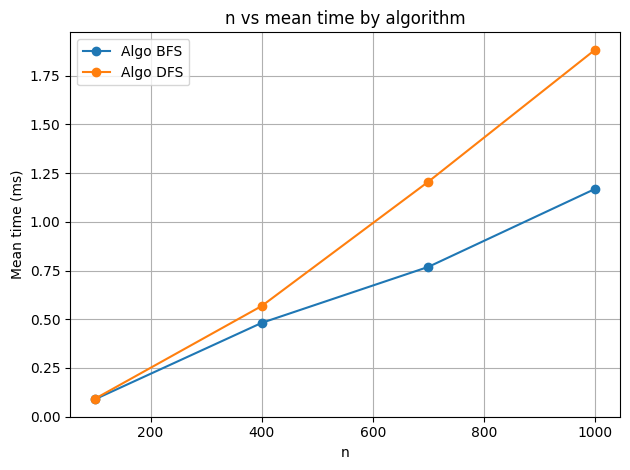

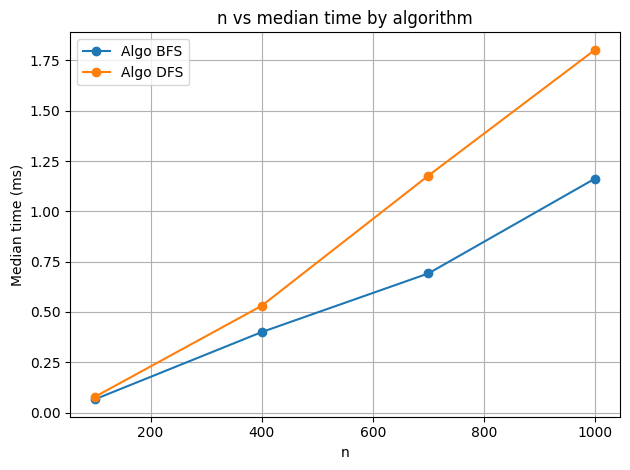

C:\Users\ASUS\AppData\Local\Temp\ipykernel_26120\4054560401.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted(df['n'].unique()))


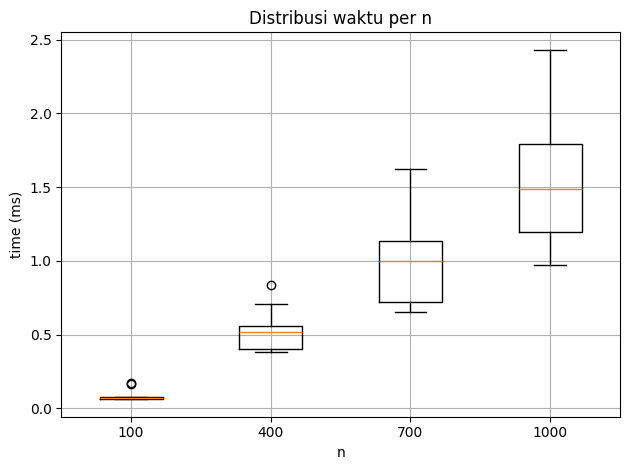

In [311]:
plt.figure()

for algo in sorted(df['algo'].unique()):
    xs=sorted(df['n'].unique())
    ys=[summary[(summary['algo']==algo)&(summary['n']==x)]['time_ms_mean'].values[0] for x in xs]
    plt.plot(xs, ys, marker='o', label=f'Algo {algo}')

plt.xlabel('n')
plt.ylabel('Mean time (ms)')
plt.title('n vs mean time by algorithm')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/plot_n_vs_mean_time.png', dpi=150)
plt.show()
plt.figure()

for algo in sorted(df['algo'].unique()):
    xs=sorted(df['n'].unique())
    ys=[summary[(summary['algo']==algo)&(summary['n']==x)]['time_ms_median'].values[0] for x in xs]
    plt.plot(xs, ys, marker='o', label=f'Algo {algo}')

plt.xlabel('n')
plt.ylabel('Median time (ms)')
plt.title('n vs median time by algorithm')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/plot_n_vs_median_time.png', dpi=150)
plt.show()
plt.figure()

data=[df[df['n']==x]['time_ms'] for x in sorted(df['n'].unique())]
plt.boxplot(data, labels=sorted(df['n'].unique()))
plt.xlabel('n')
plt.ylabel('time (ms)')
plt.title('Distribusi waktu per n')
plt.grid(True)
plt.tight_layout()
plt.savefig('results/plot_box_time_per_n.png', dpi=150)
plt.show()

## Uji Statistik (paired t-test)

In [312]:
try:
    from scipy.stats import ttest_rel

    for n in sorted(df['n'].unique()):
        a=df[(df['n']==n)&(df['algo']=='DFS')]['time_ms'].values
        b=df[(df['n']==n)&(df['algo']=='BFS')]['time_ms'].values
        t,p=ttest_rel(a,b)
        print(f'n={n}: t={t:.3f}, p={p*100:.2f}%')

except Exception as e:
    print('SciPy tidak tersedia; lewati uji t berpasangan.', e)

n=100: t=0.584, p=59.04%
n=400: t=1.586, p=18.79%
n=700: t=5.782, p=0.44%
n=1000: t=7.063, p=0.21%


## Ekspor tabel LaTeX

In [313]:
latex_table=summary.rename(columns={'time_ms_mean':'Mean (ms)','time_ms_sd':'SD (ms)','time_ms_median':'Median (ms)'}).to_latex(index=False)#,'gap_mean':'Gap'}).to_latex(index=False)

with open('results/summary.tex','w',encoding='utf-8') as f:
    f.write(latex_table)

print('Saved results/summary.tex')

Saved results/summary.tex


## Clean Memory

In [314]:
gc.collect

<function gc.collect(generation=2)>